## 1. Problem statement

We want to develop a classifier to detect ASMR from EEG data using topological features, and identify the electrodes with the strongest signal responses.

## 2. Data loading

We will use EEG data from the following study:

Swart, T. (2022, January 11). ASMR amplifies low frequency and reduces high frequency oscillations. Retrieved from osf.io/dg3y5

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from data import read_raw_data


raw_data = read_raw_data()

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 3 misc
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 512.0 Hz
>
Using matplotlib as 2D backend.


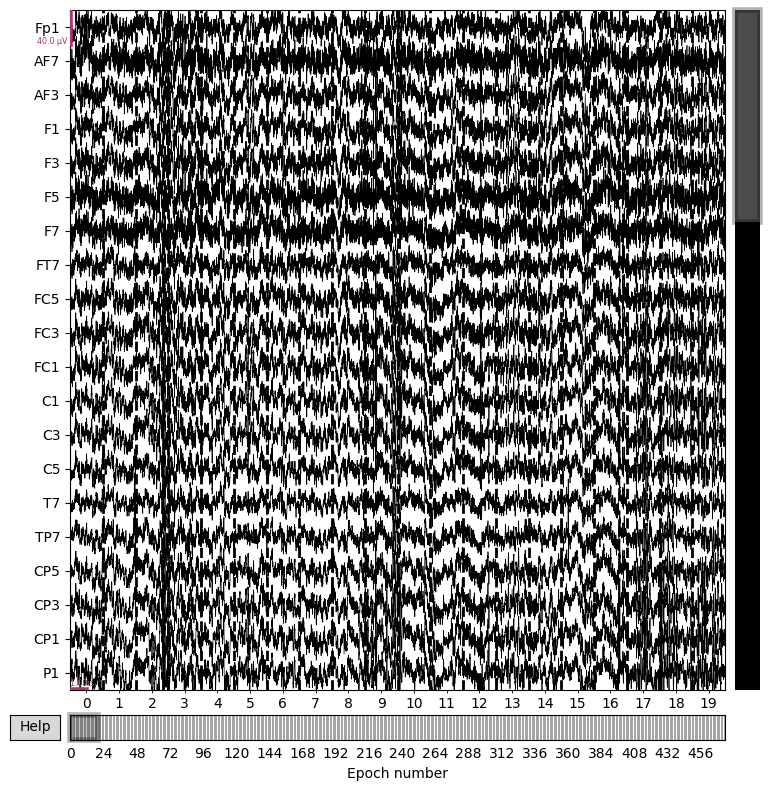

In [3]:
import matplotlib.pyplot as plt


_, raw = raw_data[0]
print(raw.info)
fig = raw.plot(show=False)
plt.show()

## 3. Data processing

The EEG data will undergo the following processing:

1) Segmentation into labeled intervals;
2) Conversion of the time series from each segment and channel into point clouds.

In [4]:
from data import extract_intervals


df = extract_intervals(raw_data)
df

,id,interval,label,ASMR
0,002,"[[-1.8779748916625974e-05, -2.0042818069458006...",B1(Pre_Baseline),False
1,002,"[[1.2216014862060546e-05, 1.1537410736083984e-...",B1(Pre_Baseline),False
2,002,"[[-3.148919641971588e-07, -3.3316106796264646e...",B1(Pre_Baseline),False
3,002,"[[-1.1134177207946776e-05, -1.2960216522216797...",B1(Pre_Baseline),False
4,002,"[[-5.894306659698486e-06, -4.900899887084961e-...",B1(Pre_Baseline),False
...,...,...,...,...
10754,081,"[[7.206916332244873e-06, 1.50133216381073e-06,...",B5(Post_Relaxed),False
10755,081,"[[-7.881077766418457e-06, -9.90039825439453e-0...",B5(Post_Relaxed),False
10756,081,"[[6.584407329559326e-06, 1.109909152984619e-05...",B5(Post_Relaxed),False
10757,081,"[[-1.712510871887207e-05, -1.994163703918457e-...",B5(Post_Relaxed),False


In [5]:
df['id'].unique().shape

(25,)

In [6]:
df['label'].unique()

array(['B1(Pre_Baseline)', 'B2(Pre_Relaxed)', 'B3(WeakASMR)',
       'B5(Post_Relaxed)', 'B4(StrongASMR)', 'B6(Post_Baseline)'],
      dtype=object)

In [7]:
df['ASMR'].unique()

array([False,  True])

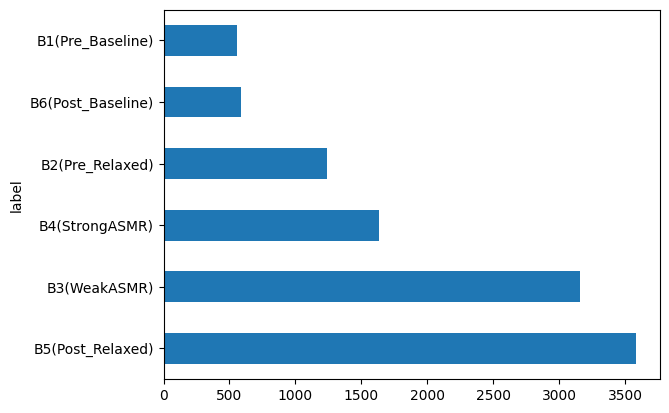

In [8]:
df['label'].value_counts().plot(kind='barh')
plt.show()

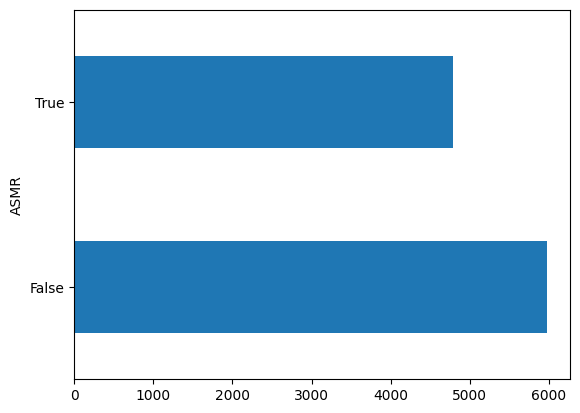

In [9]:
df['ASMR'].value_counts().plot(kind='barh')
plt.show()

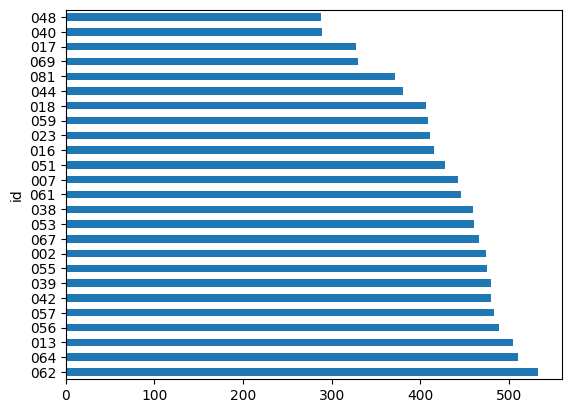

In [10]:
df['id'].value_counts().plot(kind='barh')
plt.show()

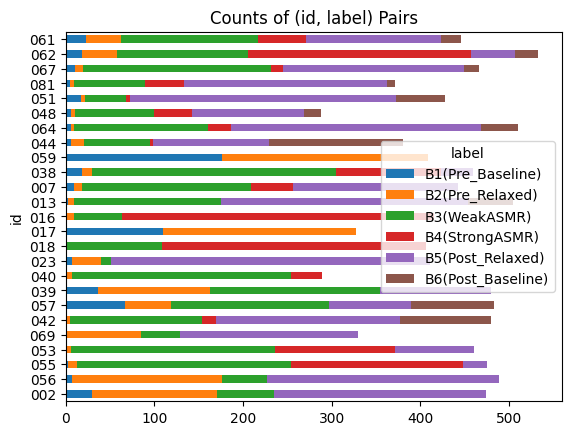

In [11]:
counts = df.groupby(['id', 'label']).size().reset_index(name='counts')
pivoted = counts.pivot(index='id', columns='label', values='counts').fillna(0)
pivoted['min_counts'] = pivoted.min(axis=1)
sorted_pivoted = pivoted.sort_values(by='min_counts')
sorted_pivoted = sorted_pivoted.drop(columns='min_counts')
sorted_pivoted.plot(kind='barh', stacked=True)
plt.ylabel('id')
plt.title('Counts of (id, label) Pairs')
plt.show()

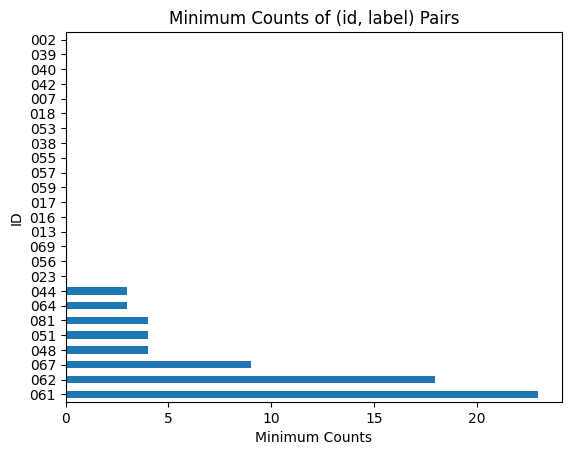

In [12]:
counts = df.groupby(['id', 'label']).size().reset_index(name='counts')
pivoted = counts.pivot(index='id', columns='label', values='counts').fillna(0)
pivoted['min_counts'] = pivoted.min(axis=1)
sorted_pivoted = pivoted.sort_values(by='min_counts', ascending=False)
sorted_pivoted['min_counts'].plot(kind='barh')
plt.xlabel('Minimum Counts')
plt.ylabel('ID')
plt.title('Minimum Counts of (id, label) Pairs')
plt.show()

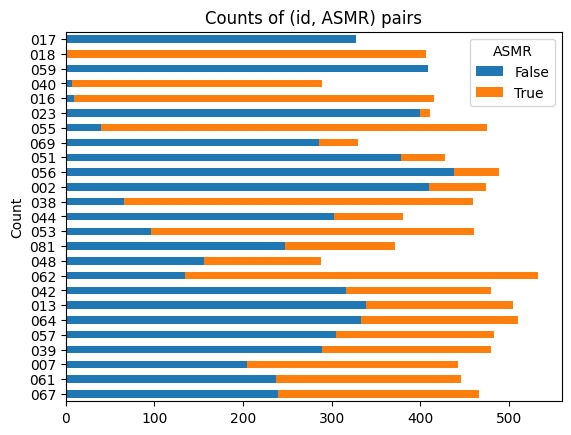

In [13]:
counts = df.groupby(['id', 'ASMR']).size().reset_index(name='counts')
pivoted = counts.pivot(index='id', columns='ASMR', values='counts').fillna(0)
pivoted['min_counts'] = pivoted.min(axis=1)
sorted_pivoted = pivoted.sort_values(by='min_counts', ascending=False)
sorted_pivoted = sorted_pivoted.drop(columns='min_counts')
sorted_pivoted.plot(kind='barh', stacked=True)
plt.ylabel('Count')
plt.title('Counts of (id, ASMR) pairs')
plt.show()

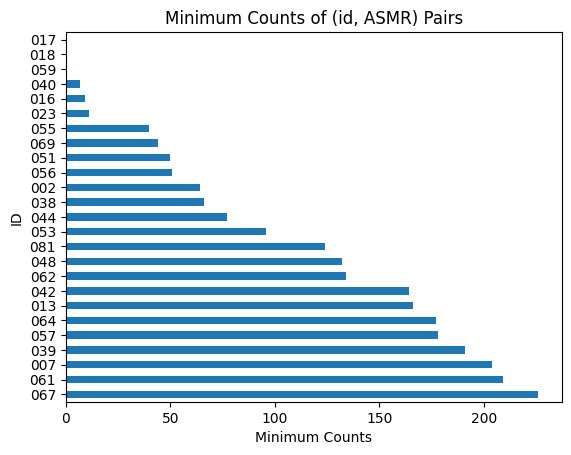

In [14]:
counts = df.groupby(['id', 'ASMR']).size().reset_index(name='counts')
pivoted = counts.pivot(index='id', columns='ASMR', values='counts').fillna(0)
pivoted['min_counts'] = pivoted.min(axis=1)
sorted_pivoted = pivoted.sort_values(by='min_counts', ascending=False)
sorted_pivoted['min_counts'].plot(kind='barh')
plt.xlabel('Minimum Counts')
plt.ylabel('ID')
plt.title('Minimum Counts of (id, ASMR) Pairs')
plt.show()

In [15]:
print(list(sorted_pivoted.index))

['067', '061', '007', '039', '057', '064', '013', '042', '062', '048', '081', '053', '044', '038', '002', '056', '051', '069', '055', '023', '016', '040', '059', '018', '017']


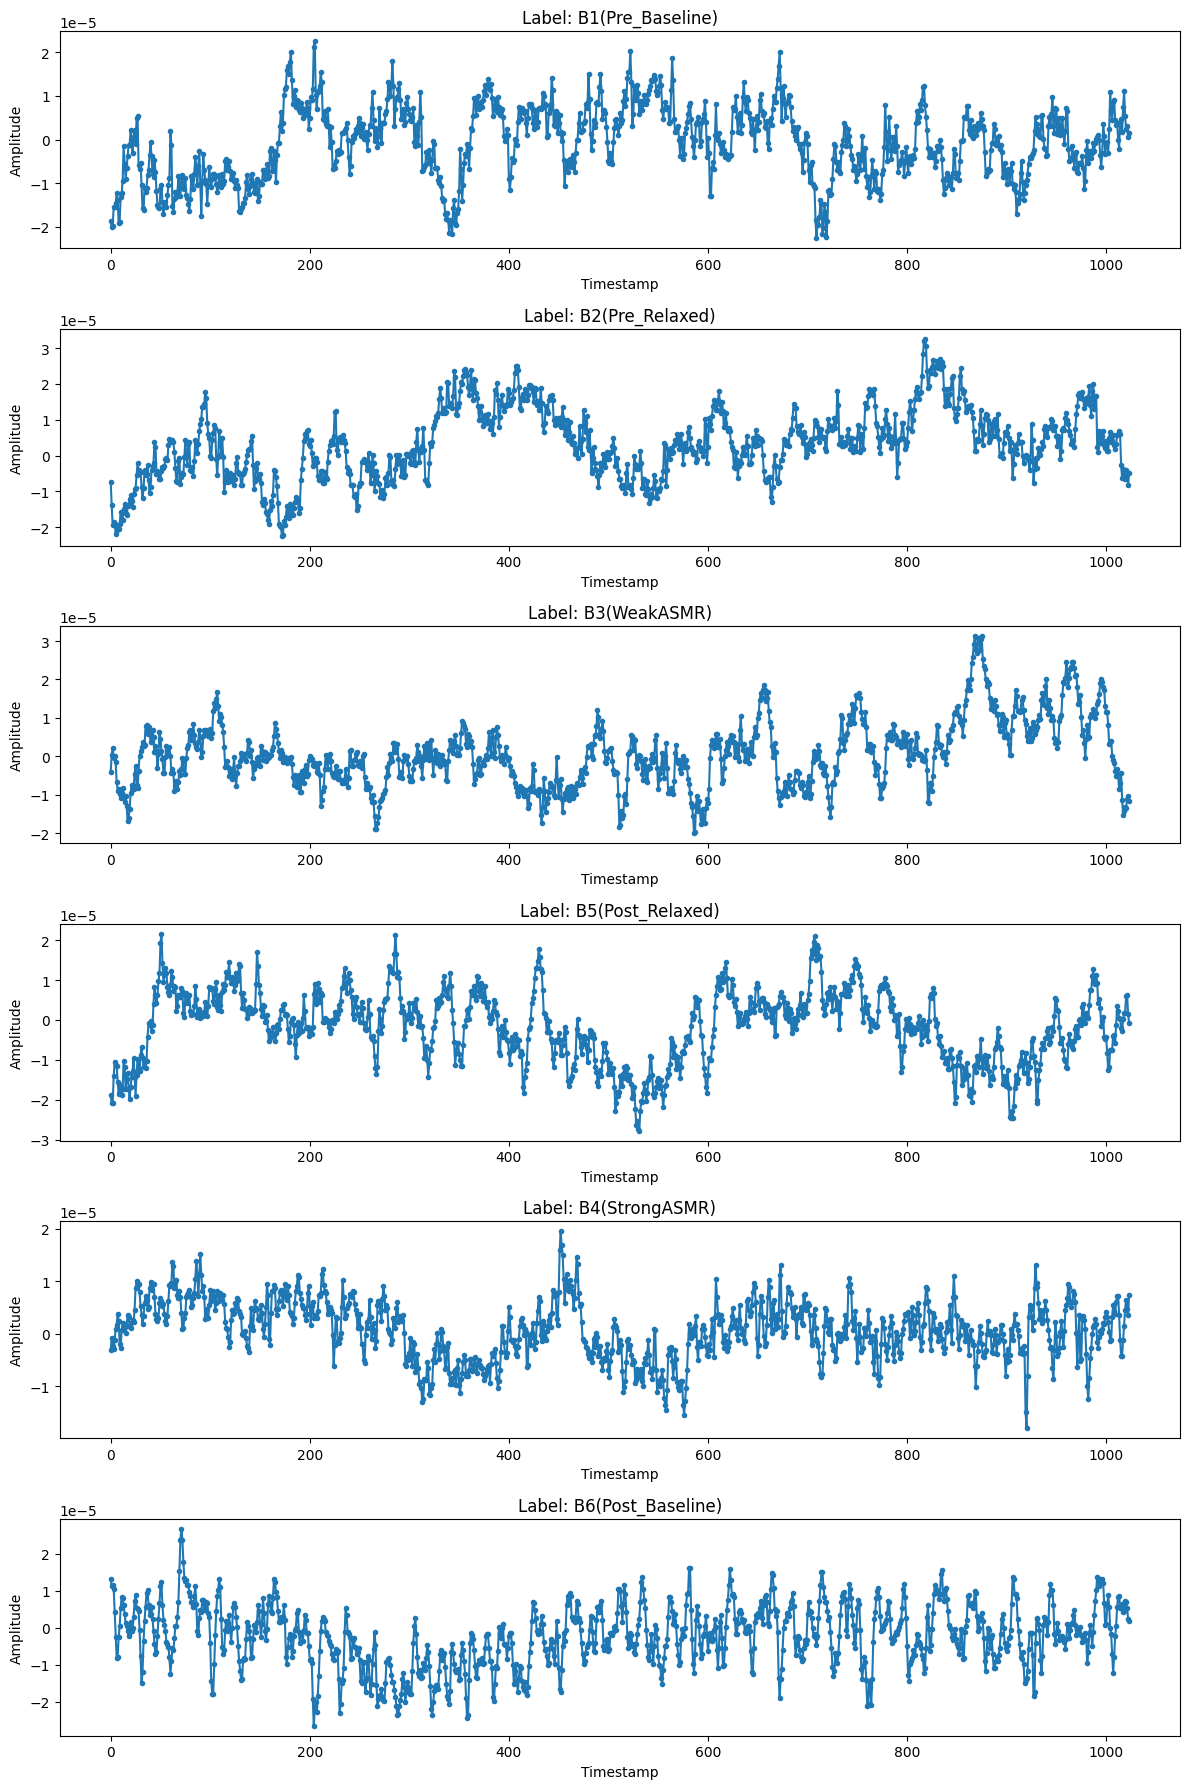

In [16]:
samples = df.groupby('label').head(1)

fig, axs = plt.subplots(nrows=len(samples), figsize=(12, len(samples) * 3))

for ax, (_, row) in zip(axs, samples.iterrows()):
    ax.plot(row['interval'][0, :], marker='.', linestyle='-') 
    ax.set_title(f"Label: {row['label']}")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [17]:
from embedding import get_embedding_statistics

emb_stats = get_embedding_statistics()
emb_stats

,id,channel,label,dimension,time_delay
0,002,Fp1,B1(Pre_Baseline),7,35
1,002,AF7,B1(Pre_Baseline),6,13
2,002,AF3,B1(Pre_Baseline),6,32
3,002,F1,B1(Pre_Baseline),9,17
4,002,F3,B1(Pre_Baseline),6,34
...,...,...,...,...,...
14459,081,P8,B6(Post_Baseline),6,36
14460,081,P10,B6(Post_Baseline),7,27
14461,081,PO8,B6(Post_Baseline),5,17
14462,081,PO4,B6(Post_Baseline),6,77


In [18]:
import pandas as pd


frequency_df = emb_stats.groupby(['dimension']).size().reset_index(name='Count')
sorted_frequency_df = frequency_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
sorted_frequency_df.head(10)

,dimension,Count
0,6,5631
1,7,3762
2,8,1930
3,5,1546
4,9,968
5,10,498
6,4,119
7,3,9
8,2,1


In [19]:
frequency_df = emb_stats.groupby(['time_delay']).size().reset_index(name='Count')
sorted_frequency_df = frequency_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
sorted_frequency_df.head(10)

,time_delay,Count
0,22,460
1,19,443
2,15,421
3,20,416
4,18,411
5,12,390
6,16,376
7,21,374
8,13,356
9,30,355


In [20]:
frequency_df = emb_stats.groupby(['dimension', 'time_delay']).size().reset_index(name='Count')
sorted_frequency_df = frequency_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
sorted_frequency_df.head(10)

,dimension,time_delay,Count
0,6,15,178
1,6,12,173
2,6,20,158
3,6,18,155
4,6,22,152
5,6,9,152
6,6,19,148
7,6,11,148
8,6,8,145
9,6,10,144


`Dimension = 6`

`Time Delay = 15`

`Stride = 1`

In [21]:
from data import compute_point_clouds


big_clouds = df.groupby('label').head(1).reset_index(drop=True)
big_clouds = compute_point_clouds(big_clouds, stride=1)
big_clouds

,id,label,ASMR,point_cloud
0,002,B1(Pre_Baseline),False,"[[[1.7565529177443186e-05, 8.076497102283834e-..."
1,002,B2(Pre_Relaxed),False,"[[[1.6941674824487983e-05, -1.400556018710667e..."
2,002,B3(WeakASMR),True,"[[[-6.546626021299498e-06, 3.4204388937583463e..."
3,002,B5(Post_Relaxed),False,"[[[5.947099025853318e-06, 2.5421765766907132e-..."
4,007,B4(StrongASMR),True,"[[[-6.607657249548175e-06, -7.950093950925056e..."
5,013,B6(Post_Baseline),False,"[[[-5.391195765387126e-06, -6.138453469389865e..."


In [22]:
big_clouds['point_cloud'].iloc[0].shape

(64, 949, 3)

Label: B1(Pre_Baseline)


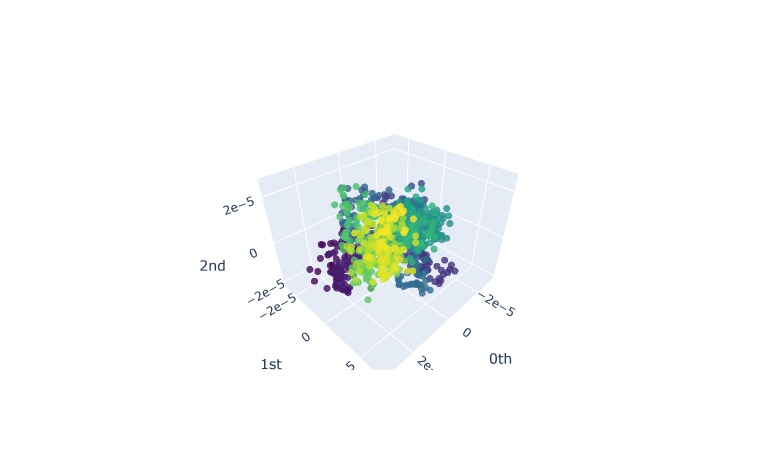

In [23]:
from gtda.plotting import plot_point_cloud

from visualization import visualize


label = 'B1(Pre_Baseline)'
print(f'Label: {label}')
fig = plot_point_cloud(big_clouds[big_clouds['label'] == label]['point_cloud'].iloc[0][0])
visualize(fig, 'point_cloud_1_big')

Label: B4(StrongASMR)


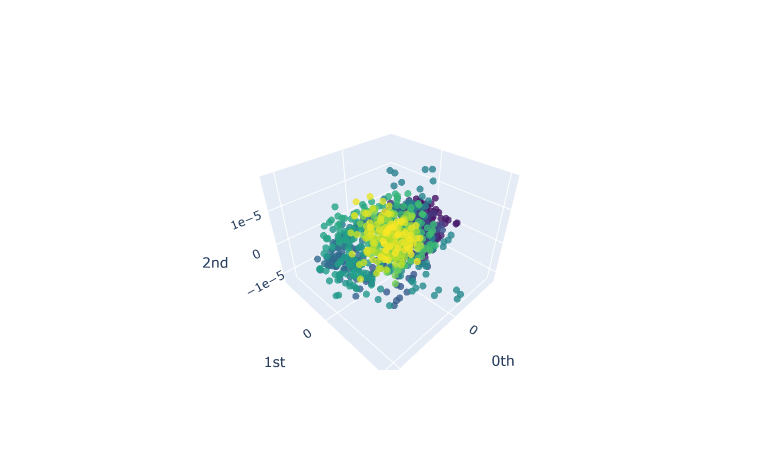

In [24]:
label = 'B4(StrongASMR)'
print(f'Label: {label}')
fig = plot_point_cloud(big_clouds[big_clouds['label'] == label]['point_cloud'].iloc[0][0])
visualize(fig, 'point_cloud_4_big')

`Stride = 10` (for computational feasibility)

In [25]:
df = df.groupby('label').head(4).reset_index(drop=True)
df = compute_point_clouds(df, stride=10)
df

,id,label,ASMR,point_cloud
0,002,B1(Pre_Baseline),False,"[[[2.2962516341206246e-05, 8.599181662709828e-..."
1,002,B1(Pre_Baseline),False,"[[[-4.253572745050168e-06, -3.260464956845413e..."
2,002,B1(Pre_Baseline),False,"[[[1.1561769428874746e-06, 7.293109971157109e-..."
3,002,B1(Pre_Baseline),False,"[[[9.026666286364041e-06, -1.2420654155156363e..."
4,002,B2(Pre_Relaxed),False,"[[[-2.86698330868522e-05, -1.0145914297306156e..."
5,002,B2(Pre_Relaxed),False,"[[[6.389481482094032e-06, 1.1608473229400861e-..."
6,002,B2(Pre_Relaxed),False,"[[[4.397272407014308e-07, -2.2707333121607177e..."
7,002,B2(Pre_Relaxed),False,"[[[-2.459098254943879e-06, -2.2008163285504756..."
8,002,B3(WeakASMR),True,"[[[-6.607748410254112e-06, -8.99908525584515e-..."
9,002,B3(WeakASMR),True,"[[[-1.416615750882418e-05, 7.843462464230975e-..."


In [26]:
df['point_cloud'].iloc[0].shape

(64, 95, 3)

Label: B1(Pre_Baseline)


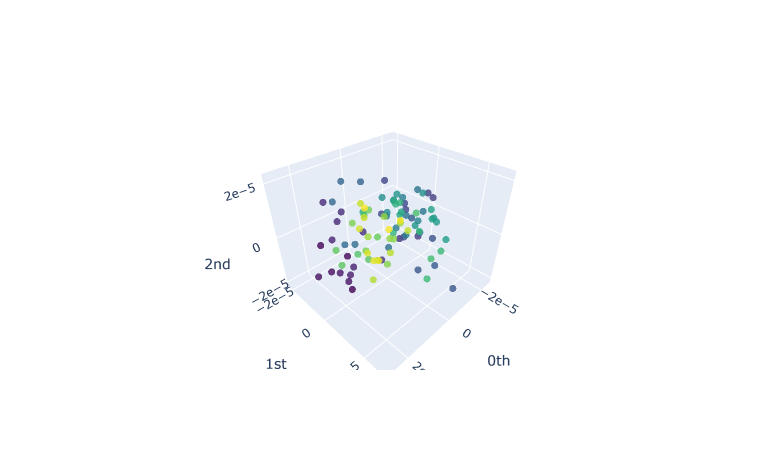

In [27]:
label = 'B1(Pre_Baseline)'
print(f'Label: {label}')
fig = plot_point_cloud(df[df['label'] == label]['point_cloud'].iloc[0][0])
visualize(fig, 'point_cloud_1')

Label: B4(StrongASMR)


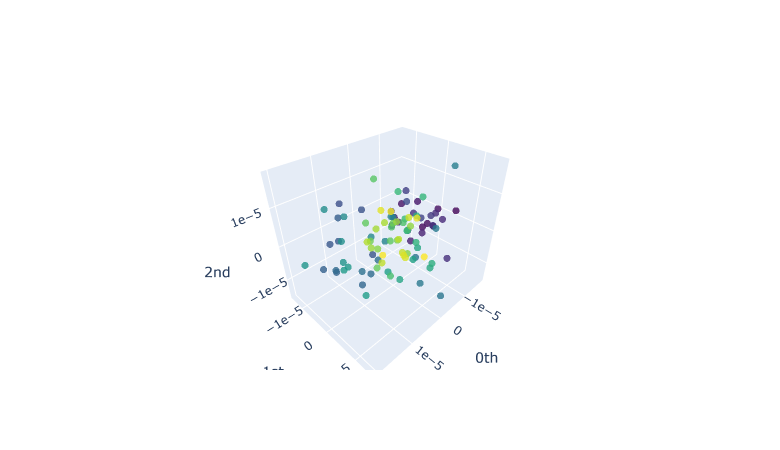

In [28]:
label = 'B4(StrongASMR)'
print(f'Label: {label}')
fig = plot_point_cloud(df[df['label'] == label]['point_cloud'].iloc[0][0])
visualize(fig, 'point_cloud_4')

## 4. Topological feature extraction

In [29]:
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram


VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])

samples = df.groupby('label').head(1).sort_values(by='label')

def plot_persistence_diagram(samples, idx):
    print(f"Label: {samples['label'].iloc[idx]}")
    diagrams = VR.fit_transform(samples['point_cloud'].iloc[idx])
    fig = plot_diagram(diagrams[0])
    visualize(fig, f'persistence_diagram_{idx+1}')

Label: B1(Pre_Baseline)


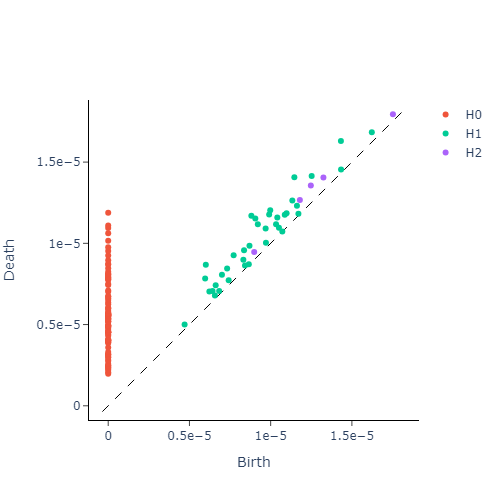

In [30]:
plot_persistence_diagram(samples, 0)

Label: B4(StrongASMR)


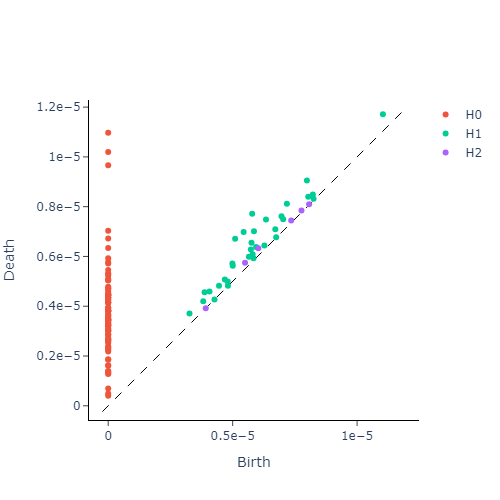

In [31]:
plot_persistence_diagram(samples, 3)

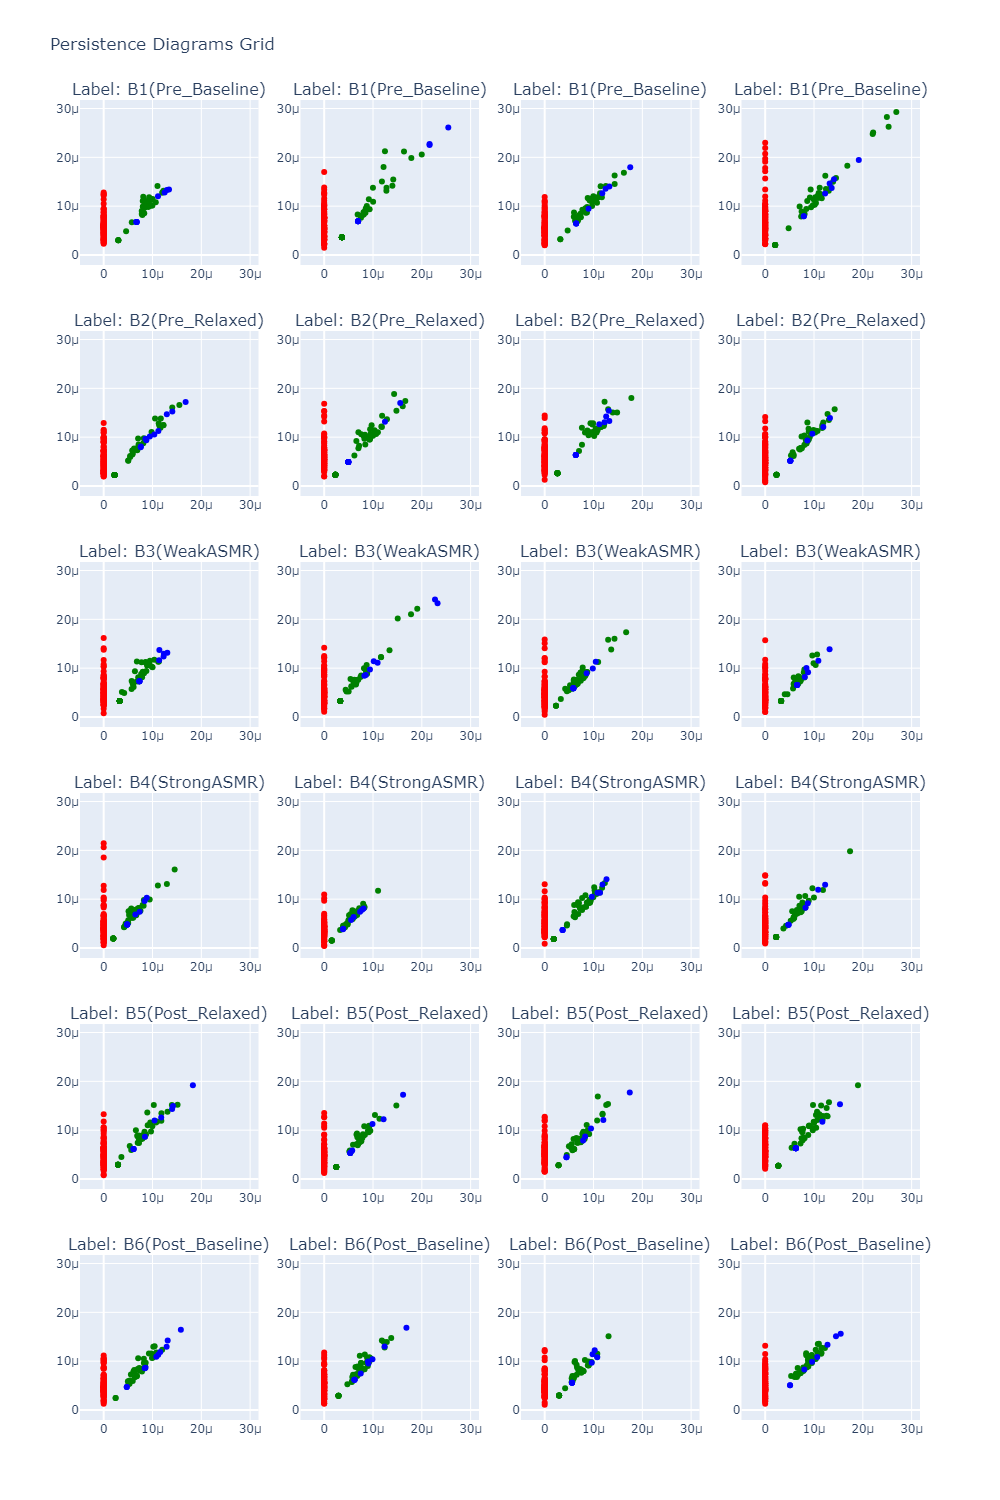

In [32]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from config import SEED


n_samples = 4

samples = df.groupby('label').sample(n=n_samples, random_state=SEED).reset_index(drop=True)

labels = sorted(df['label'].unique())

fig = make_subplots(rows=6, 
                    cols=n_samples, 
                    subplot_titles=[f'Label: {label}' for label in labels for _ in range(n_samples)], 
                    vertical_spacing=0.05)

row = 1
col = 1

for label in labels:
    for idx in range(n_samples):
        sample = samples[(samples['label'] == label)].iloc[idx]
        diagrams = VR.fit_transform(sample['point_cloud'])
        diagram = diagrams[0] # Only the first channel is used

        conditions = [
            diagram[:, 2] == 0,
            diagram[:, 2] == 1,
            diagram[:, 2] == 2
        ]
        choices = ['red', 'green', 'blue']
        colors = np.select(conditions, choices)

        trace = go.Scatter(x=diagram[:, 0], y=diagram[:, 1], mode='markers', marker=dict(color=colors))
        
        fig.add_trace(trace, row=row, col=col)
        
        if col < n_samples:
            col += 1
        else:
            col = 1
            row += 1

fig.update_xaxes(matches='x')
fig.update_yaxes(matches='y', scaleanchor='x', scaleratio=1)

fig.update_layout(height=1500, width=1000, title_text='Persistence Diagrams Grid', showlegend=False)
visualize(fig, 'persistence_diagrams_grid')

## 5. Classification

In [33]:
from data import get_training_data


X_train, X_val, y_train, y_val = get_training_data()

In [34]:
X_train

,id,channel,amplitude_0,amplitude_1,amplitude_2,entropy_0,entropy_1,entropy_2,Betti_0,Betti_1,Betti_2
0,067,Fp1,1.434655e-08,2.103286e-09,5.444574e-10,6.396502,4.395749,1.290928,94,30,4
1,067,AF7,1.454235e-08,3.297450e-09,4.897121e-10,6.409569,4.366407,1.659775,94,28,4
2,067,AF3,1.986100e-08,3.223479e-09,2.076207e-10,6.393715,4.492312,2.089599,94,34,5
3,067,F1,2.199529e-08,5.468221e-09,4.329474e-10,6.392104,4.328775,0.630056,94,31,2
4,067,F3,2.061750e-08,4.078958e-09,6.436077e-10,6.329304,4.208513,0.637534,94,28,2
...,...,...,...,...,...,...,...,...,...,...,...
1275,067,P8,4.325002e-08,2.754574e-09,6.450763e-10,6.363612,4.449382,1.734107,94,30,4
1276,067,P10,1.970855e-08,1.950496e-09,4.803300e-10,6.422152,4.632239,1.465686,94,36,3
1277,067,PO8,2.350960e-08,3.378644e-09,1.295689e-09,6.455000,4.656244,2.118169,94,35,6
1278,067,PO4,2.980297e-08,4.377053e-09,1.243217e-09,6.430155,4.742199,1.867487,94,33,5


In [35]:
X_val

,id,channel,amplitude_0,amplitude_1,amplitude_2,entropy_0,entropy_1,entropy_2,Betti_0,Betti_1,Betti_2
0,067,Fp1,9.999110e-09,7.808433e-09,1.048171e-10,6.450507,4.123739,0.000000,94,26,1
1,067,AF7,1.776988e-08,3.810037e-09,1.166060e-09,6.465776,4.622697,1.868529,94,34,4
2,067,AF3,1.872600e-08,6.614251e-09,1.394170e-09,6.473330,4.436504,0.646584,94,36,3
3,067,F1,2.211313e-08,5.717527e-09,4.323862e-10,6.452489,4.352827,0.550987,94,28,2
4,067,F3,1.608882e-08,6.675457e-09,4.619232e-10,6.455609,4.385896,1.562766,94,34,4
...,...,...,...,...,...,...,...,...,...,...,...
1275,067,P8,3.532263e-08,5.545533e-09,9.236868e-10,6.401782,4.524378,2.347322,94,32,6
1276,067,P10,1.535995e-08,3.825277e-09,5.812513e-11,6.456027,4.278521,1.514266,94,29,3
1277,067,PO8,3.070665e-08,4.754984e-09,1.140397e-09,6.435127,4.624500,2.142575,94,33,6
1278,067,PO4,4.321482e-08,6.747781e-09,1.774932e-09,6.412649,4.259482,0.138567,94,25,2


In [36]:
y_train.value_counts()

ASMR
False    640
True     640
Name: count, dtype: int64

In [37]:
y_val.value_counts()

ASMR
False    640
True     640
Name: count, dtype: int64

In [38]:
from pipeline import run_experiment

run_experiment()

Training Samples: 	1280
Training Accuracy: 	0.60
Training Precision: 	0.61
Training Recall: 	0.58
Training F1 Score: 	0.60
Training ROC AUC: 	0.67
Validation Samples: 	1280
Validation Accuracy: 	0.48
Validation Precision: 	0.48
Validation Recall: 	0.48
Validation F1 Score: 	0.48
Validation ROC AUC: 	0.47

Execution Time: 0.03 seconds


## 6. Experiments

In [16]:
import pandas as pd

from config import EXPERIMENTS_RESULTS_FILE


results = pd.read_pickle(EXPERIMENTS_RESULTS_FILE)

results[['Classifier', 'Training Samples', 'Intervals per Person per Class', 'Train Validation Same People',
       'Number of People', 'Training ROC AUC', 'Validation ROC AUC', 'Experiment Goal']]

,Classifier,Training Samples,Intervals per Person per Class,Train Validation Same People,Number of People,Training ROC AUC,Validation ROC AUC,Experiment Goal
0,DecisionTree,1280,10,True,1,1.000000,0.514062,"Try some pairs of (train, validation) sets"
1,DecisionTree,2560,20,True,1,1.000000,0.511328,"Try some pairs of (train, validation) sets"
2,DecisionTree,3840,30,True,1,1.000000,0.511198,"Try some pairs of (train, validation) sets"
3,DecisionTree,5120,40,True,1,1.000000,0.509766,"Try some pairs of (train, validation) sets"
4,DecisionTree,6400,50,True,1,1.000000,0.496406,"Try some pairs of (train, validation) sets"
5,DecisionTree,12800,100,True,1,1.000000,0.497500,"Try some pairs of (train, validation) sets"
6,DecisionTree,12800,100,True,1,1.000000,0.497500,Compare classifiers
7,LogisticRegression,12800,100,True,1,0.554624,0.499197,Compare classifiers
8,SVM,12800,100,True,1,0.693835,0.509504,Compare classifiers
9,KNeighbors,12800,100,True,1,0.750994,0.502715,Compare classifiers
